In [1]:
# cnn model with batch normalization for mnist
import tensorflow as tf
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
 

In [2]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


In [3]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


In [4]:
# Helper function to resize image proportionally. size is a tuple (height,width)
def resize_image(img, size): 
    from PIL import Image, ImageOps     
    # resize the image so the longest dimension matches our target size
    img.thumbnail(size, Image.ANTIALIAS)   
    # Create a new square white background image
    newimg = Image.new("RGB", size, (255, 255, 255))  
    # Paste the resized image into the center of the square background
    if np.array(img).shape[2] == 4:
        # If the source is in RGBA format, use a mask to eliminate the transparency
        newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)), mask=img.split()[3])
    else:
        newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return newimg


In [5]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
    # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories
 

In [7]:
def fit_model(trainX, trainY, testX, testY):
    model = define_model()
    # split train and test dataset
#    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.3) # 70% training and 30% test

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=1)
    _, acc = model.evaluate(testX, testY, verbose=1)
    # save model
    model.save("final_model.h5")
    return acc, history   

In [20]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    plt.figure(figsize=(20,10))
    for i in range(len(histories)):
        # plot loss
        plt.subplot(1, 2, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.legend(['train', 'test'], loc='upper left')

        # plot accuracy
        plt.subplot(1, 2, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.legend(['train', 'test'], loc='upper left')

    plt.show()

In [21]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()


In [22]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    print(trainX.shape,testX.shape)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
#    scores, histories = evaluate_model(trainX, trainY)
    score, history = fit_model(trainX, trainY, testX, testY)
    # learning curves
#    summarize_diagnostics(histories)
    summarize_diagnostics([history])


(60000, 28, 28, 1) (10000, 28, 28, 1)
Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1236 - accuracy: 0.9637 - val_loss: 0.0618 - val_accuracy: 0.9805
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0460 - accuracy: 0.9867 - val_loss: 0.0444 - val_accuracy: 0.9852
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.0416 - val_accuracy: 0.9868
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0392 - val_accuracy: 0.9872
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0376 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0419 - val_accuracy: 0.9884
Epoch 7/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0055 - accuracy: 0.9

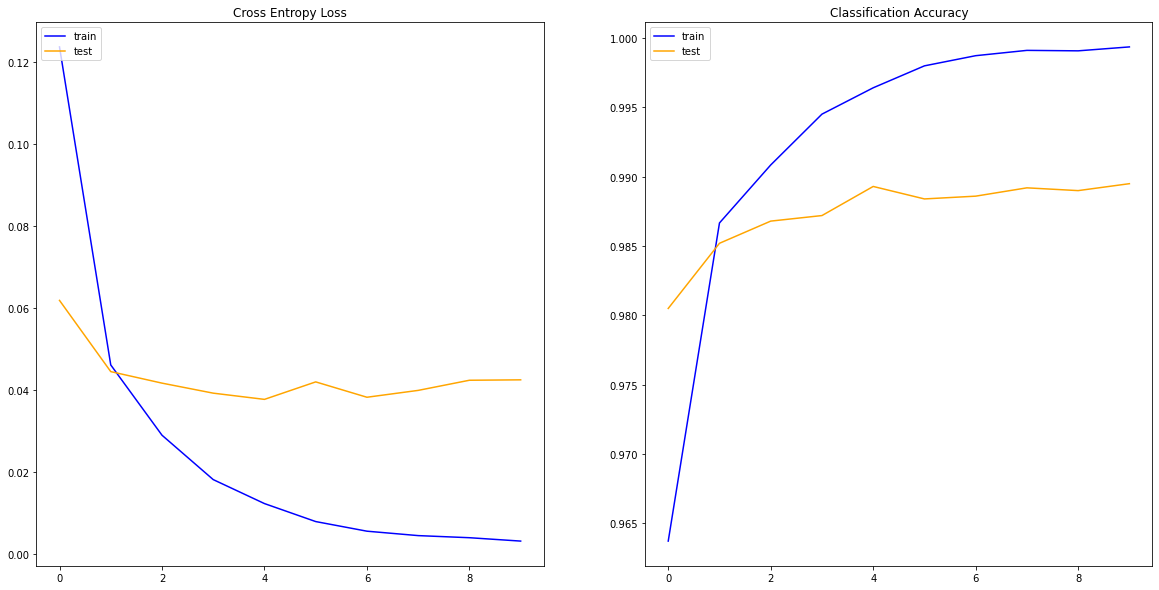

In [23]:
# entry point, run the test harness
run_test_harness()

In [24]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
 
# load and prepare the image
def load_image(filename):
    # load the image and convert to grayscale
    img = load_img(filename, color_mode = "grayscale", target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('sample_image.png')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    digit = model.predict_classes(img)
    print("predict number =",digit[0])

# entry point, run the example
run_example()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
predict number = 7


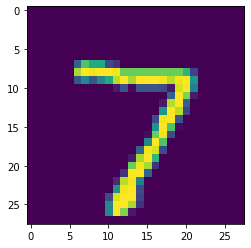

In [28]:
img = load_image('sample_image.png')
# reshape from (1,28,28,1) to (28,28,1)
img = img.reshape(28,28,1)
plt.imshow(img)
plt.show()